In [15]:
import sys
import os
import importlib
import yfinance as yf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# add utils path
utils_path = os.path.abspath('../../utils')
if utils_path not in sys.path:
    sys.path.append(utils_path)

# import util functions
from stats import pca, fit_regression, forecast_arima

# reload module on change
importlib.reload(sys.modules['stats'])

<module 'stats' from 'c:\\Users\\Yang\\Documents\\Projects\\funance_blog\\utils\\stats.py'>

## PCA

In [2]:
START_DATE = '2019-01-01'
END_DATE = '2023-12-31'

# market indexes
index_funds = pd.read_csv('../data/indexes.csv')
index_tickers = index_funds['ticker'].tolist()

In [3]:
df = pca(index_tickers, START_DATE, END_DATE, frequency='1mo')

[*********************100%%**********************]  12 of 12 completed


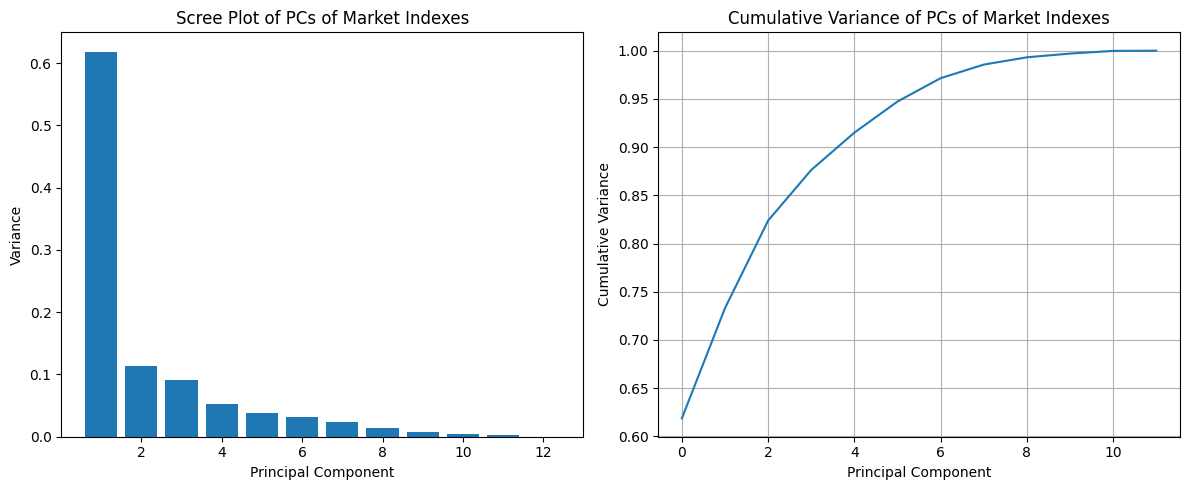

In [4]:
# scree plot
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].bar(range(1, len(df['variance'])+1), df['variance'])
ax[0].set_xlabel('Principal Component')
ax[0].set_ylabel('Variance')
ax[0].set_title('Scree Plot of PCs of Market Indexes')

ax[1].plot(np.cumsum(df['variance']))
ax[1].set_xlabel('Principal Component')
ax[1].set_ylabel('Cumulative Variance')
ax[1].set_title('Cumulative Variance of PCs of Market Indexes')
ax[1].grid()

fig.tight_layout()

C:\Users\Yang\AppData\Local\Temp\ipykernel_968\158003390.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[n].set_xticklabels(names, rotation=30, ha='right')
C:\Users\Yang\AppData\Local\Temp\ipykernel_968\158003390.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[n].set_xticklabels(names, rotation=30, ha='right')
C:\Users\Yang\AppData\Local\Temp\ipykernel_968\158003390.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[n].set_xticklabels(names, rotation=30, ha='right')


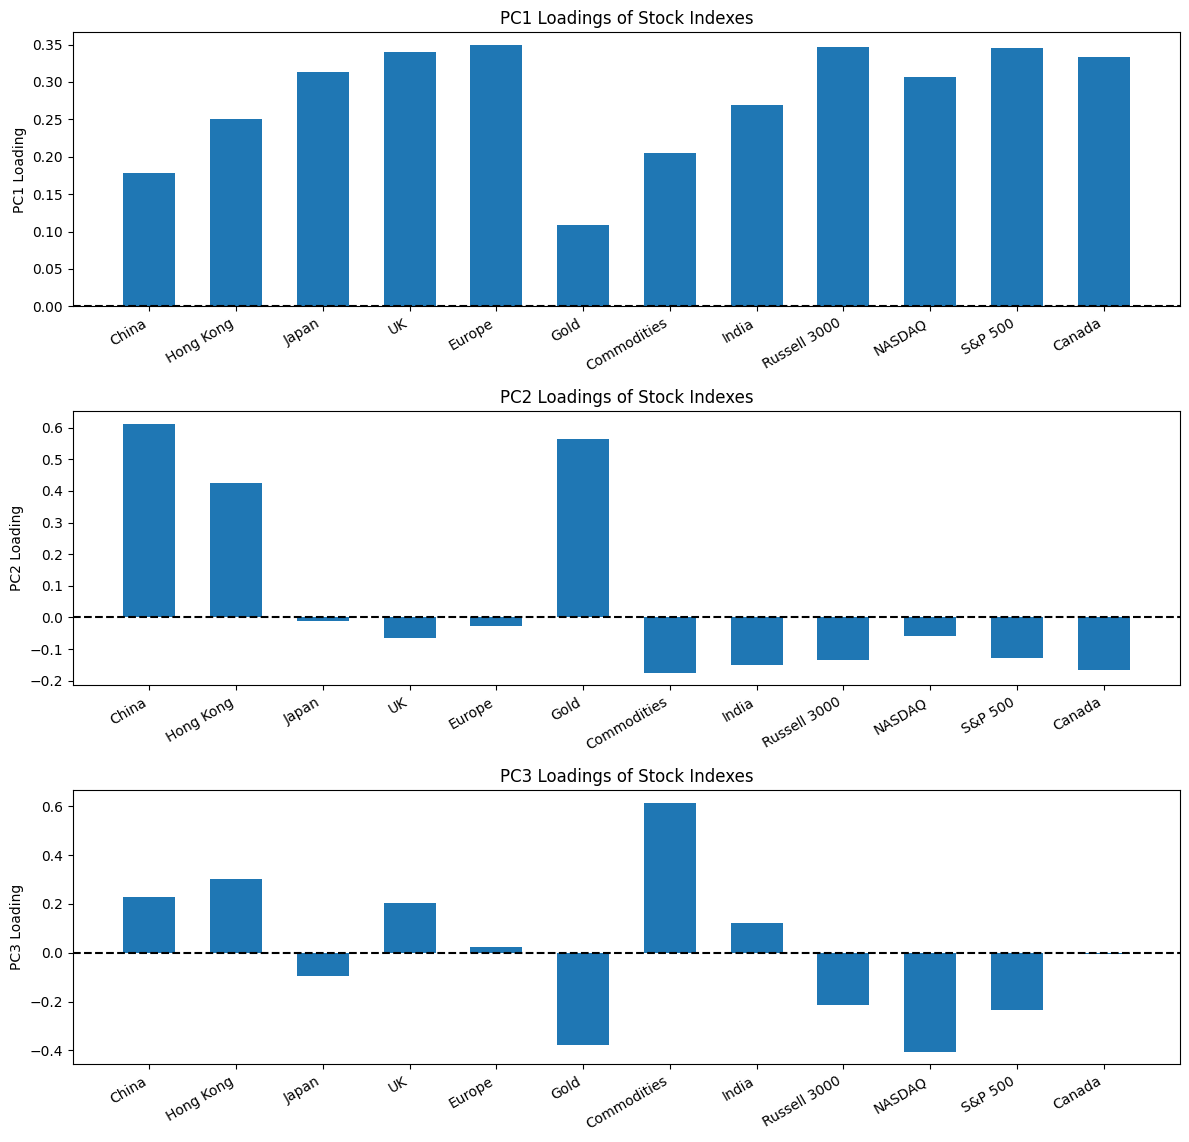

In [5]:
# looking at first 3 principal components
pcs = 3
names = [
    index_funds[index_funds['ticker'] == t]['shortName'].values[0] for t in df['loadings'].columns
]

fig, ax = plt.subplots(pcs, 1, figsize=(12, 12))

for n in range(pcs): 
    ax[n].bar(names, df['loadings'].iloc[n], width=0.6)
    ax[n].set_title(f'PC{n+1} Loadings of Stock Indexes')
    ax[n].set_xticklabels(names, rotation=30, ha='right')
    ax[n].set_ylabel(f'PC{n+1} Loading')
    ax[n].axhline(0, color='black', linestyle='--')

fig.tight_layout(rect=[0, 0, 1, 0.96])

Text(0.5, 0, 'Principal Component 3')

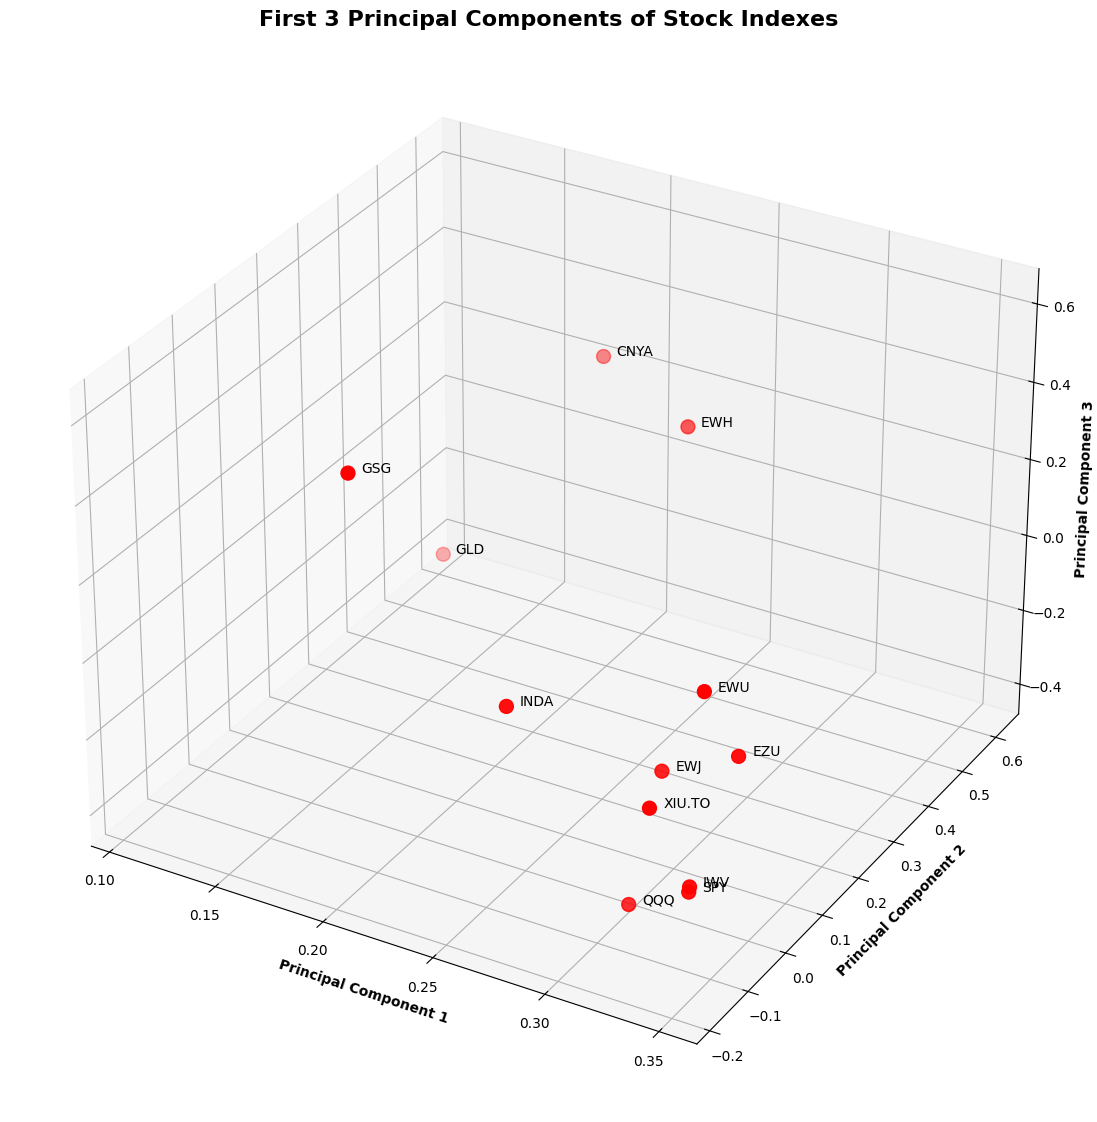

In [6]:
# visualize in 3d space
fig = plt.figure(figsize=(14, 14))
ax = plt.axes(projection='3d')

ax.scatter3D(
    df['loadings'].iloc[0, :],
    df['loadings'].iloc[1, :], 
    df['loadings'].iloc[2, :],
    color='r',
    marker='o',
    s=100,
)
for i, t in enumerate(df['loadings'].columns):
    ax.text(
        df['loadings'].iloc[0, i]+0.005,
        df['loadings'].iloc[1, i]+0.005, 
        df['loadings'].iloc[2, i]+0.005,
        t,
        zorder=0,
    )
    
plt.title('First 3 Principal Components of Stock Indexes', fontweight='bold', fontsize=16)
ax.set_xlabel('Principal Component 1', fontweight ='bold')
ax.set_ylabel('Principal Component 2', fontweight ='bold')
ax.set_zlabel('Principal Component 3', fontweight ='bold')

## Factor Analysis

In [7]:
factors_df = pd.read_csv('../data/fama_french_momentum_daily.csv')
factors_df['Date'] = pd.to_datetime(factors_df['Date'])
factors_df.set_index('Date', inplace=True)

In [8]:
factors_df.tail()

,Mkt-RF,SMB,HML,RF,Mom
Date,,,,,
2024-06-24,-0.26,0.26,1.11,0.022,-0.79
2024-06-25,0.31,-0.55,-1.20,0.022,1.21
2024-06-26,0.16,0.10,-0.20,0.022,-0.42
2024-06-27,0.14,0.70,-0.36,0.022,-0.23
2024-06-28,-0.35,0.72,1.29,0.022,0.35


In [9]:
def daily_to_monthly(df):
    df = df / 100
    monthly_df = df.resample('ME').apply(lambda x: (1 + x).prod() - 1) * 100
    return monthly_df

In [10]:
start_date = '2019-01-01'
end_date = '2023-12-31'
ticker = 'CRWD'

price = yf.download(ticker, start=start_date, end=end_date)['Adj Close']
r_i = price.pct_change().dropna() * 100 # daily returns

price_start = price.index[0]
price_end = price.index[-1]

# prepare data
x = factors_df.loc[price_start:price_end].copy()
x = x.iloc[1:] # match length with r_i
y = r_i - x['RF'] # excess return

# convert to monthly returns
x = daily_to_monthly(x)
y = daily_to_monthly(y)

results = fit_regression(
    x[['Mkt-RF', 'SMB', 'HML', 'Mom']], 
    y, 
    print_summary=True
)

[*********************100%%**********************]  1 of 1 completed

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.401
Model:                            OLS   Adj. R-squared:                  0.353
Method:                 Least Squares   F-statistic:                     8.355
Date:                Wed, 07 Aug 2024   Prob (F-statistic):           3.05e-05
Time:                        17:14:43   Log-Likelihood:                -215.01
No. Observations:                  55   AIC:                             440.0
Df Residuals:                      50   BIC:                             450.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.7634      1.740      1.588      0.1

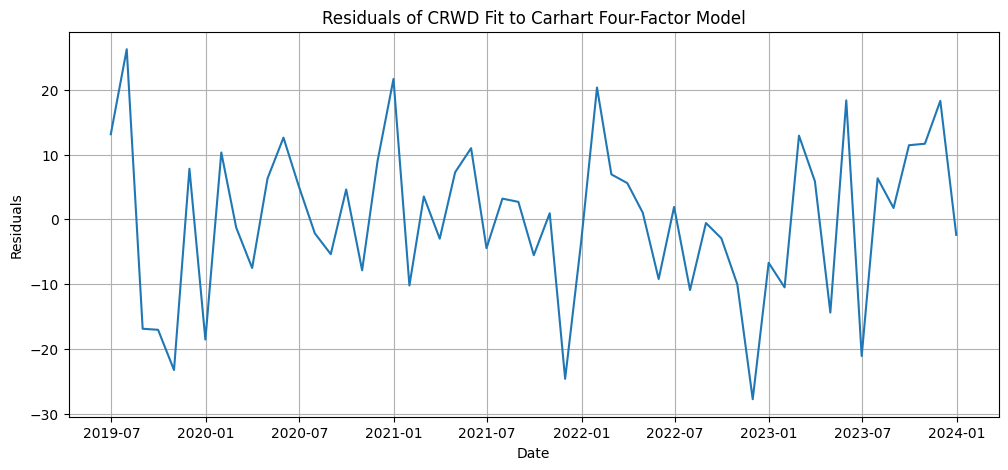

In [11]:
plt.figure(figsize=(12, 5))
plt.plot(y.index, results['residuals'])
plt.title(f'Residuals of {ticker} Fit to Carhart Four-Factor Model')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.grid()
plt.show()

## ARIMA Forecasting

In [20]:
forecasts = {}

for col in x.columns:
    forecasts[col] = forecast_arima(x[col])

In [21]:
# calculate expected returns using Carhart four-factor model
expected_return = (
    results['params']['const'] + \
    results['params']['Mkt-RF'] * forecasts['Mkt-RF']['forecast'] + \
    results['params']['SMB'] * forecasts['SMB']['forecast'] + \
    results['params']['HML'] * forecasts['HML']['forecast'] + \
    results['params']['Mom'] * forecasts['Mom']['forecast'] + \
    forecasts['RF']['forecast']
)

In [23]:
date = forecasts['Mkt-RF']['date']
print(f'Expected Return of CRWD for month ending on {date}: {expected_return:.2f}%')

Expected Return of CRWD for month ending on 2024-01-31: 6.64%
